In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
#d_opts = [('cuda', torch.cuda.is_available()), ('mps', torch.backends.mps.is_available()), ('cpu', True)]
#device = next(device for device, available in d_opts if available)
device = 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [10]:
def load_data(dir_name: str):
    data = list()
    with open(dir_name, "r") as f:
        [data.append(np.array(line.split(","), dtype=np.float32)) for line in f]
    data = np.asarray(data)
    return data[:,1:], data[:,0]

In [13]:
Xtr, Ytr = load_data("data/mnist_train.csv")
Xval, Yval = load_data("data/mnist_test.csv")

# rescale 0-255 to 0.0-1.0
Xtr = Xtr/Xtr.max()
Xval = Xval/Xval.max()

# one-hot encoding
ytr = np.zeros((Ytr.size, int(Ytr.max()) + 1))
ytr[np.arange(Ytr.size), Ytr.astype(int)] = 1.0

yval = np.zeros((Yval.size, int(Yval.max()) + 1))
yval[np.arange(Yval.size), Yval.astype(int)] = 1.0

Xtr, Ytr = torch.tensor(Xtr, requires_grad=True, device=device), torch.tensor(ytr, requires_grad=True, device=device)
Xval, Yval = torch.tensor(Xval, requires_grad=True, device=device), torch.tensor(yval, requires_grad=True, device=device)

print(f"Training set size: {Xtr.shape[0]}x{Xtr.shape[1]}")
print(f"Testing set size: {Xval.shape[0]}x{Xval.shape[1]}")

Training set size: 60000x784
Testing set size: 10000x784


In [14]:
class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784, 128)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(128, 10)
        self.act_output = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.act1(self.h1(X))
        X = self.act_output(self.output(X))
        return X

In [23]:
torch.manual_seed(42)

epochs = 1000
eval_itr = 100
lossi = []
learning_rate = 1e-3

model = MNIST().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
start_time = time.time()
for i in range(epochs):
    model.train()
    # forward
    out = model.forward(Xtr)
    loss = loss_fn(out, Ytr)
    # backward
    optimizer.zero_grad()
    loss.backward()
    # update
    optimizer.step()
    # stats
    if i % eval_itr == 0:
        print(f'{i}: loss {loss.item():.2f}')
    lossi.append(loss.item())
end_time = time.time()
print(f'time to train {end_time - start_time:.1f}s')

0: loss 2.30
100: loss 1.60
200: loss 1.56
300: loss 1.53
400: loss 1.52
500: loss 1.51
600: loss 1.51
700: loss 1.50
800: loss 1.50
900: loss 1.49
time to train 75.6s


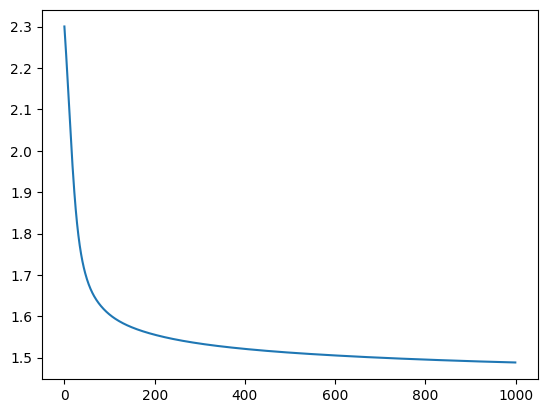

In [26]:
plt.plot(lossi);

In [27]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [28]:
y_pred = model(Xval)
acc = accuracy_fn(y_pred=y_pred.argmax(dim=1),
                 y_true=Yval.argmax(dim=1))
print(f'Accuracy: {acc:.2f}%')

Accuracy: 96.43%


In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "MNIST_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

In [30]:
# todo: 
# 1. batching
# 2. change model architecture
# 3. get running on mps